## Notebook for tuning opsin response.
### Currently the notebook is setup to deliver 100Hz spike train to the opsin and then record how the channel and cell. There are two inputs
1. stable 
    * 100Hz for 200ms so a total of 20 light pulses
2. unstable
    * 100Hz but only for 2ms so only 1 light pulse

In [1]:
from neuron import h
import numpy as np

# load neuron files
h.load_file('stdrun.hoc')
h.load_file('templates.hoc')


--No graphics will be displayed.


1.0

In [2]:
# Simulation control
h.secondorder = 2
h.dt = 0.05  
h.steps_per_ms = 1 / h.dt
h.tstop = 2000 
h.celsius = 31
v_init = -70
freq_of_input = 20
duration_of_input = 1000
start_time = 200

# read cell
cell = h.CP_Cell()

def generate_pulse_train(freq, duration, start_time):
    # freq in Hz, duration in ms, dt in ms
    isi = 1000.0 / freq
    n_pulses = int(duration / isi)
    return np.arange(start_time, n_pulses * isi+start_time, isi)

# Read pulse file or generate input on the fly 
pulse_file = "./unstable.txt"
pulse_rec = np.loadtxt(pulse_file)  # Load pulse data

pulse_rec = generate_pulse_train(freq_of_input, duration=duration_of_input, start_time=start_time)
input_vec = h.Vector(pulse_rec)
vec_stim = h.VecStim()
vec_stim.play(input_vec)

# ChR2 setup
soma1_p = h.ChR2_william_event(cell.soma[0](0.5))
soma1_p.nPulses = 1
soma1_p.Dt_on = 2
soma1_p.Dt_off = (1 / 10 * 1000) - 5
soma1_p.gmax = 0.04
soma1_p.tauChR2 = 0.4
soma1_p.Gd1 = 0.25 # was 0.25
soma1_p.Gd2 = 0.5 
soma1_p.light_intensity = 1 # This would change based of depth
soma1_p.pulse_width = 5 # width of the light pulse
soma1_p.wavelength = 523 # dont think this matter much 

# Optogenetic stimulation
input_vec = h.Vector(pulse_rec)
vec_stim = h.VecStim()
vec_stim.play(input_vec)

opto = h.NetCon(vec_stim, soma1_p)
opto.weight[0] = 1
opto.delay = 0

# Record variables
t = h.Vector().record(h._ref_t)
v = h.Vector().record(cell.soma[0](0.5)._ref_v)
i = h.Vector().record(soma1_p._ref_i)

# Run simulation
h.finitialize(v_init)
h.run()

0.0

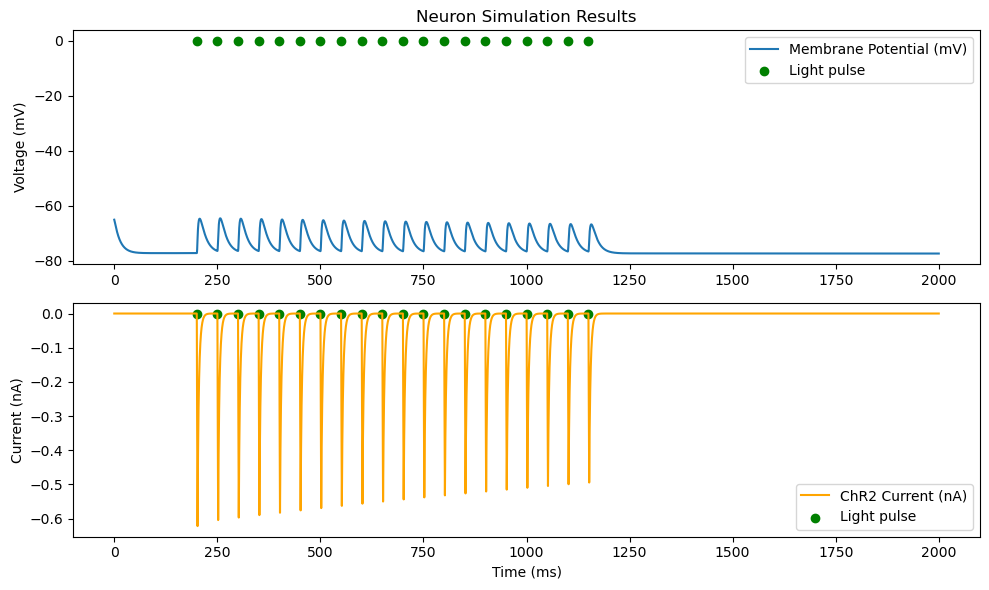

In [3]:
import matplotlib.pyplot as plt

y = []
for j in range(len(pulse_rec)):
    y.append(0)

fig, ax = plt.subplots(2, 1, figsize=(10, 6))

ax[0].plot(t, v, label="Membrane Potential (mV)")
ax[0].scatter(pulse_rec, [0] * len(pulse_rec), label='Light pulse', c='g')
ax[0].set_ylabel("Voltage (mV)")
ax[0].set_title("Neuron Simulation Results")
ax[0].legend()


ax[1].plot(t, i, label="ChR2 Current (nA)", color="orange")
ax[1].scatter(pulse_rec, [0] * len(pulse_rec), label='Light pulse', c='g')
ax[1].set_xlabel("Time (ms)")
ax[1].set_ylabel("Current (nA)")
ax[1].legend()


plt.tight_layout()

# Show the plot
plt.show()

/tmp/ipykernel_3824579/2176150419.py:33: RuntimeWarning: overflow encountered in exp
  popt, _ = curve_fit(lambda t, a, tau: a * np.exp(-t / tau), dt * np.arange(decay_len), isyn[ipk:iend+1], p0=(peak, dt * decay_len / 2))


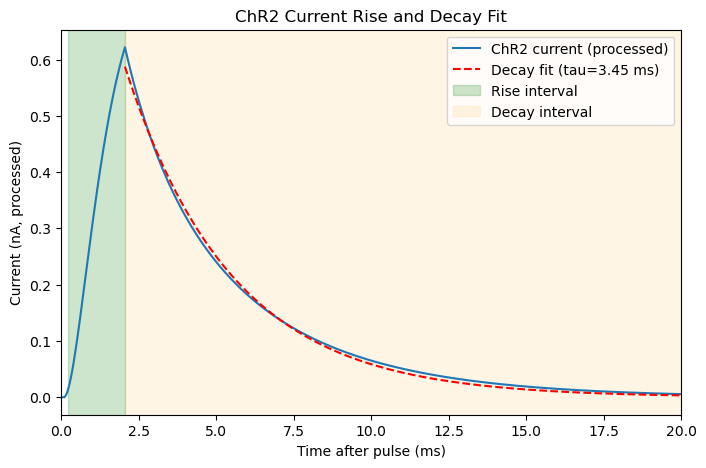

Rise time: 1.85 ms
Decay time constant: 3.4470322679265304 ms


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

def find_first(arr):
    idx = np.where(arr)[0]
    return idx[0] if idx.size else None

def get_rise_decay(i, t, pulse_rec, rise_interval=(0.01, 0.99), dt=0.05):
    tspk = pulse_rec[0]
    ispk = int(np.floor(tspk / dt))
    isyn = np.array(i)[ispk:]
    tseg = np.array(t)[ispk:] - tspk
    baseline = isyn[0]
    isyn = isyn - baseline
    sign = np.sign(isyn[np.argmax(np.abs(isyn))])
    isyn = isyn * sign
    ipk_arr, _ = find_peaks(isyn)
    ipk = ipk_arr[0] if ipk_arr.size else np.argmax(isyn)
    peak = isyn[ipk]
    istart = find_first(np.diff(isyn[:ipk+1]) > 0)
    rt1 = find_first(isyn[istart:ipk+1] > rise_interval[0] * peak) if istart is not None else None
    rt2 = find_first(isyn[istart:ipk+1] > rise_interval[1] * peak) if istart is not None else None
    rise_time = (rt2 - rt1) * dt if rt1 is not None and rt2 is not None else None
    iend = find_first(np.diff(isyn[ipk:]) > 0)
    iend = isyn.size - 1 if iend is None else iend + ipk
    decay_len = iend - ipk + 1
    decay_time = None
    fit_curve = None
    if decay_len > 3:
        try:
            popt, _ = curve_fit(lambda t, a, tau: a * np.exp(-t / tau), dt * np.arange(decay_len), isyn[ipk:iend+1], p0=(peak, dt * decay_len / 2))
            decay_time = popt[1]
            fit_curve = popt[0] * np.exp(-dt * np.arange(decay_len) / decay_time)
        except Exception as e:
            decay_time = None
    return {"rise_time": rise_time, "decay_time": decay_time, "istart": istart, "ipk": ipk, "rt1": rt1, "rt2": rt2, "iend": iend, "fit_curve": fit_curve, "tseg": tseg, "isyn": isyn}

result = get_rise_decay(i, t, pulse_rec, dt=h.dt)

plt.figure(figsize=(8,5))
plt.plot(result['tseg'], result['isyn'], label='ChR2 current (processed)')
if result['fit_curve'] is not None:
    plt.plot(result['tseg'][result['ipk']:result['ipk']+len(result['fit_curve'])], result['fit_curve'], 'r--', label=f"Decay fit (tau={result['decay_time']:.2f} ms)")
if result['rt1'] is not None and result['rt2'] is not None and result['istart'] is not None:
    plt.axvspan(result['tseg'][result['istart']+result['rt1']], result['tseg'][result['istart']+result['rt2']], color='green', alpha=0.2, label='Rise interval')
plt.axvspan(result['tseg'][result['ipk']], result['tseg'][result['iend']], color='orange', alpha=0.1, label='Decay interval')
plt.xlabel('Time after pulse (ms)')
plt.ylabel('Current (nA, processed)')
plt.title('ChR2 Current Rise and Decay Fit')
plt.xlim(0,20)
plt.legend()
plt.show()
print(f"Rise time: {result['rise_time']} ms")
print(f"Decay time constant: {result['decay_time']} ms")

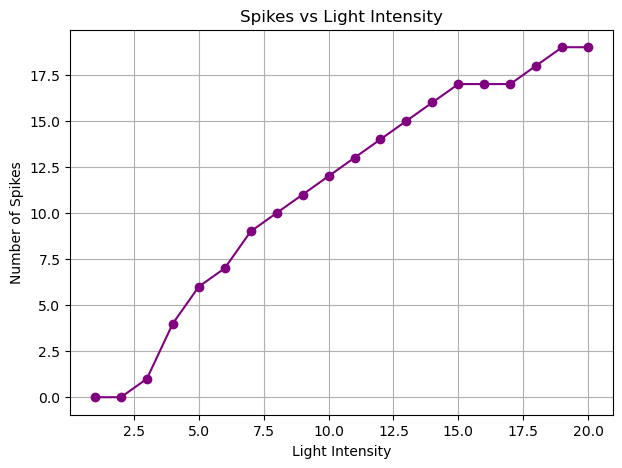

In [5]:
intensities = np.arange(1, 21)
spike_counts = []
v_traces = []
Chr2_current = []

for intensity in intensities:
    #change intensity
    soma1_p.light_intensity = intensity
    # Re-run simulation
    h.finitialize(v_init)
    h.run()
    # Convert recorded voltage to numpy array
    v_arr = np.array(v)
    # Detect spikes: threshold crossing (e.g., -20 mV)
    spike_thresh = -20
    spikes = np.where((v_arr[1:] > spike_thresh) & (v_arr[:-1] <= spike_thresh))[0]
    spike_counts.append(len(spikes))
    v_traces.append(v_arr.copy())
    Chr2_current.append(np.array(i))

plt.figure(figsize=(7,5))
plt.plot(intensities, spike_counts, 'o-', color='purple')
plt.xlabel('Light Intensity')
plt.ylabel('Number of Spikes')
plt.title('Spikes vs Light Intensity')
plt.grid(True)
plt.show()

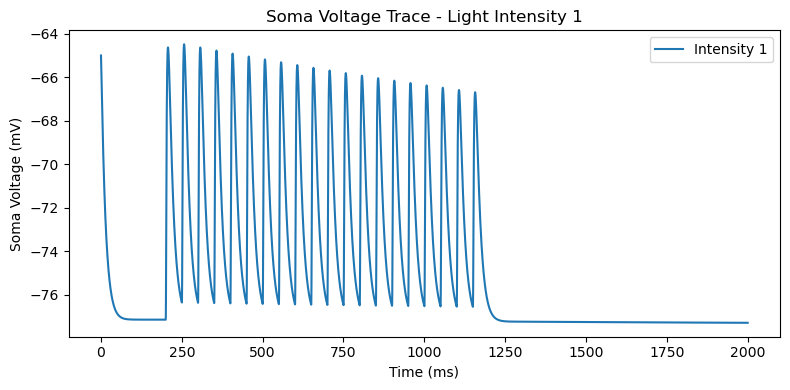

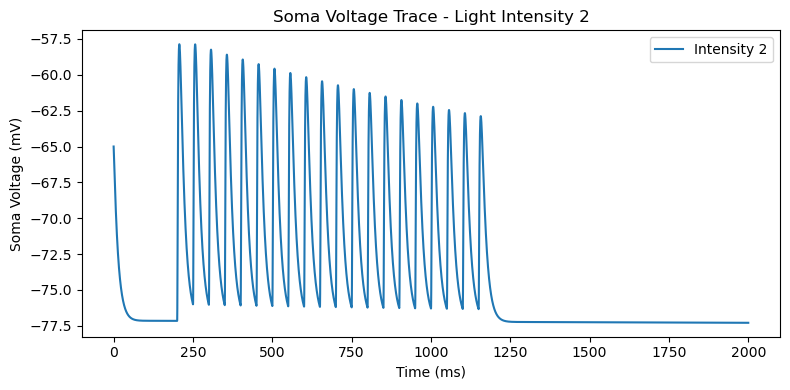

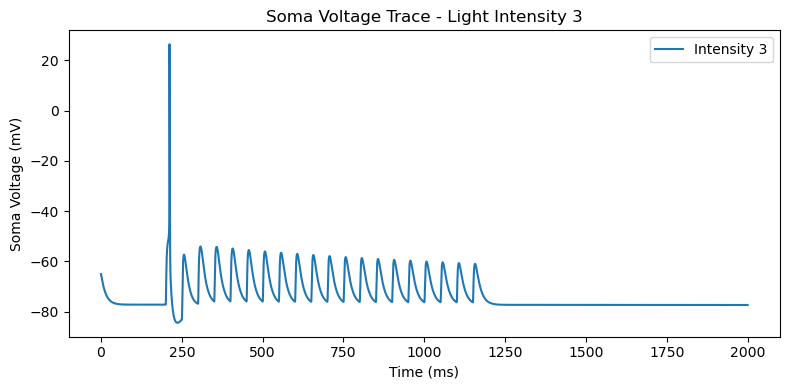

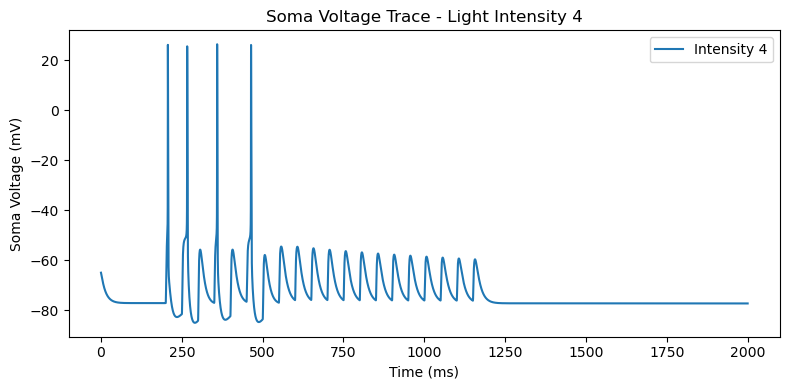

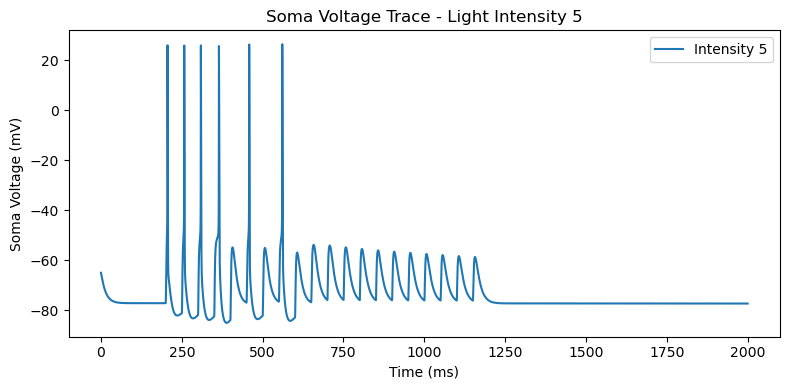

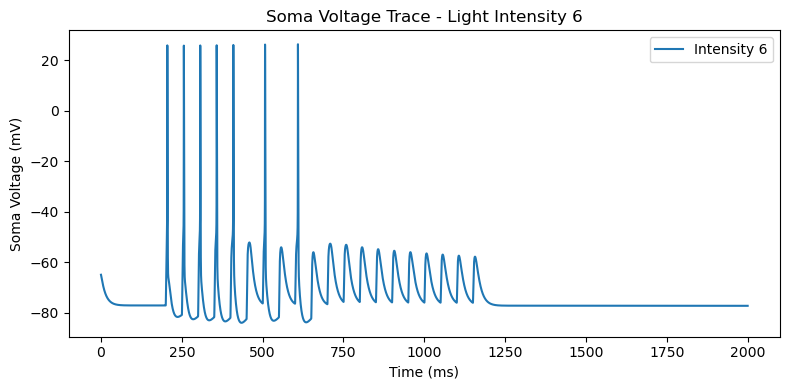

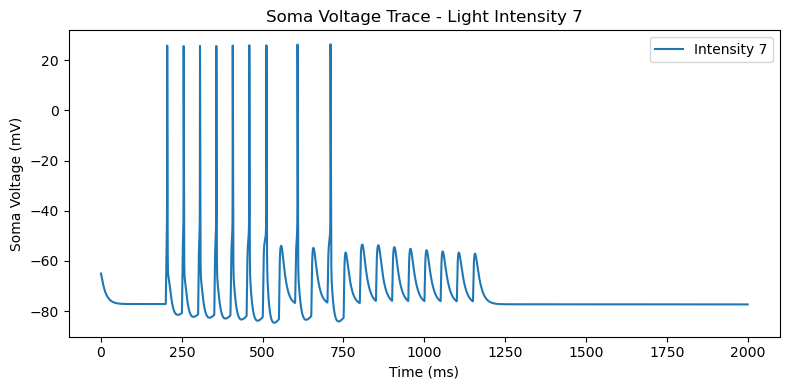

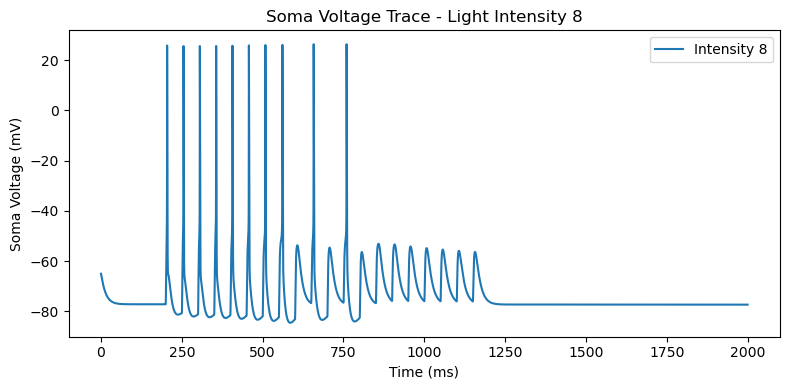

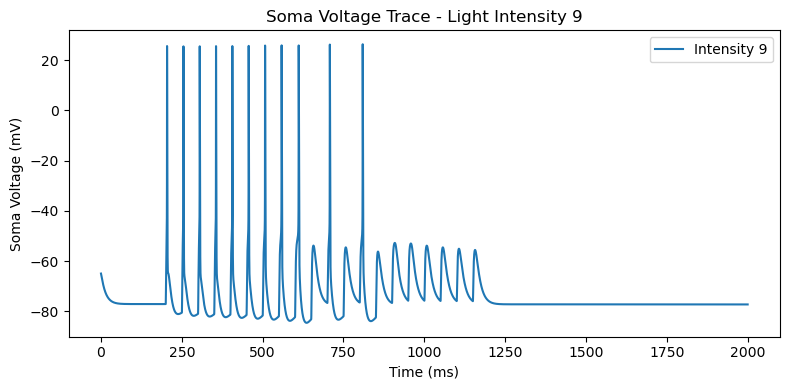

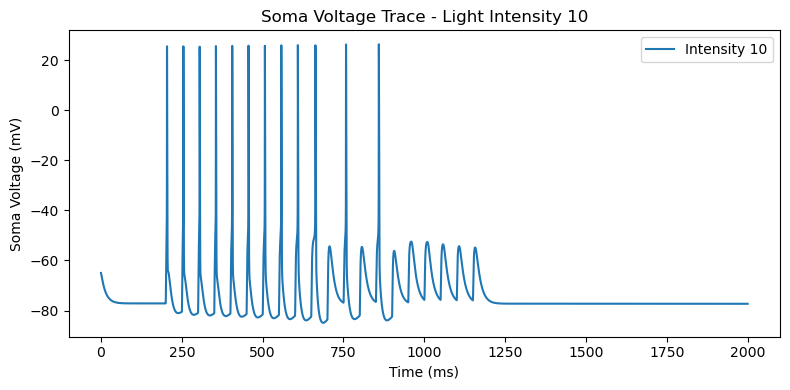

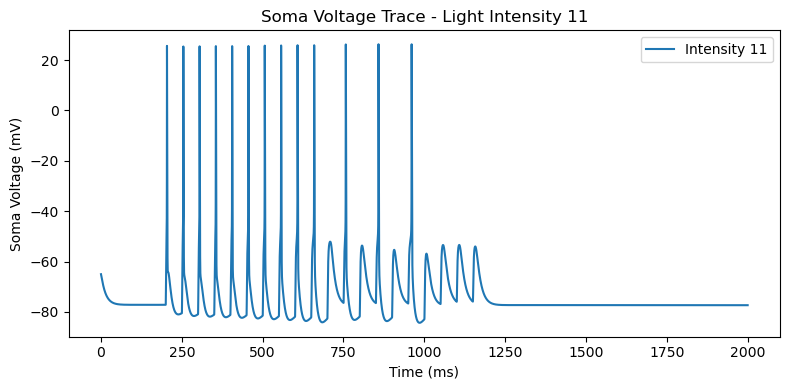

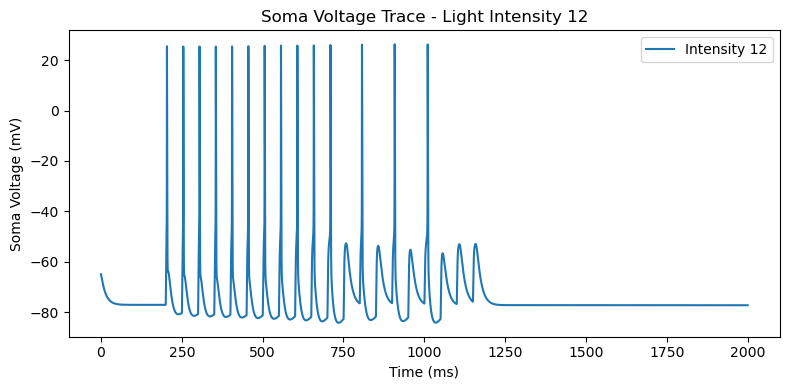

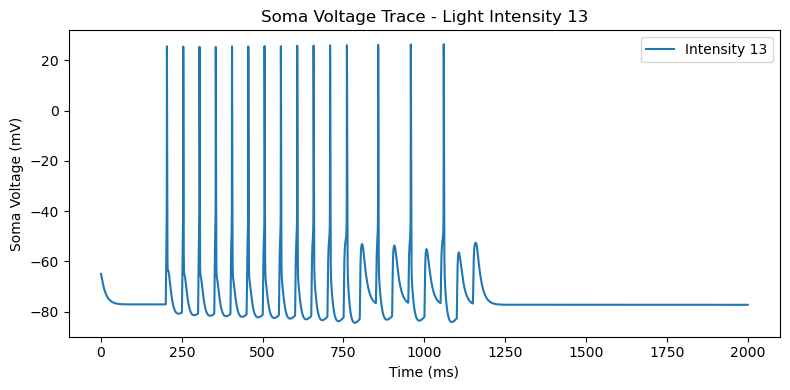

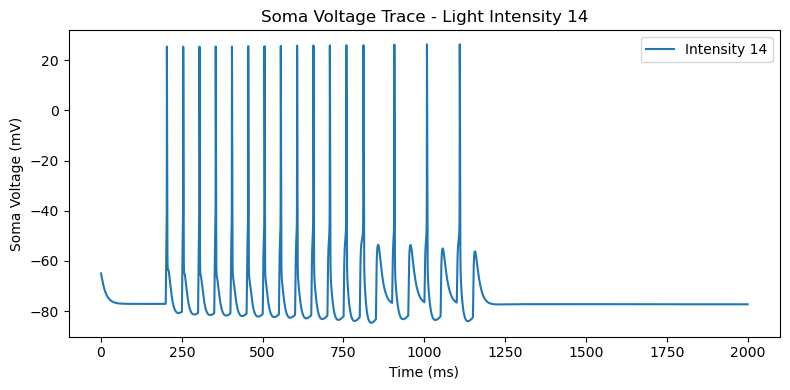

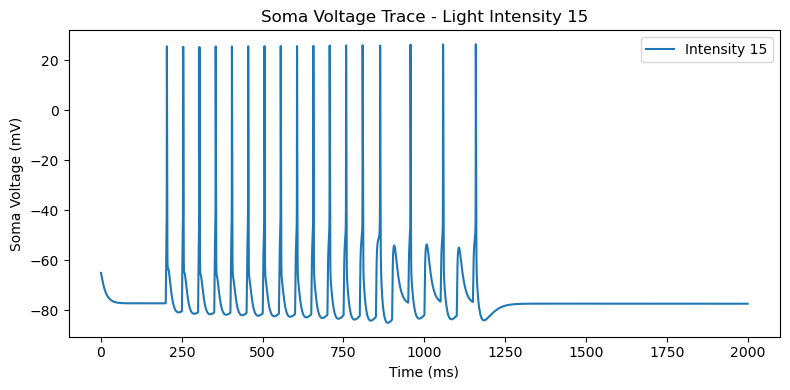

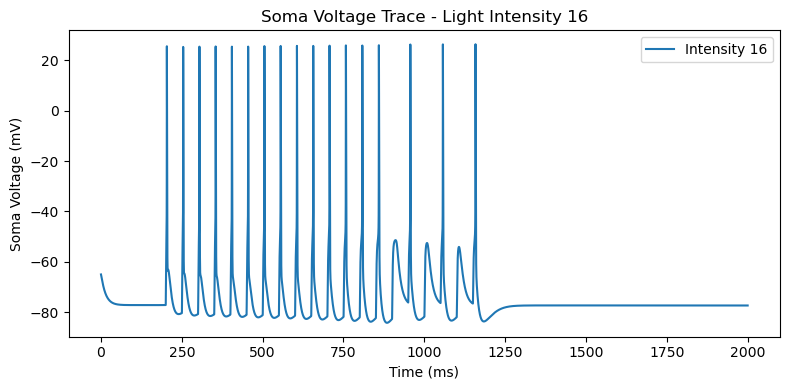

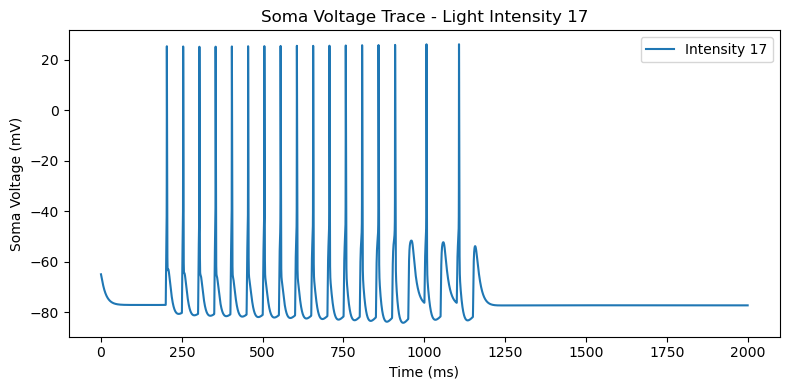

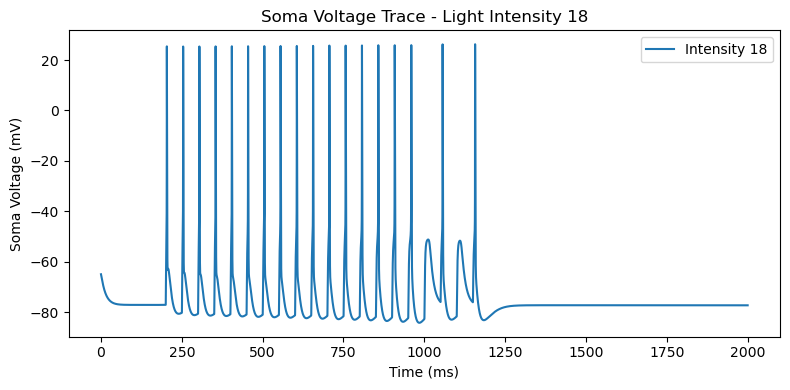

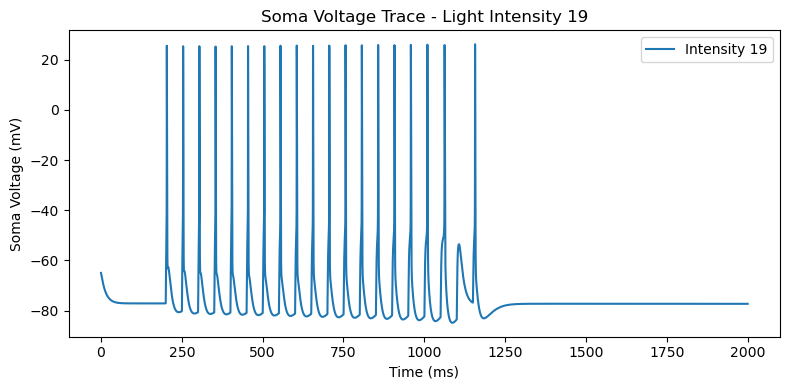

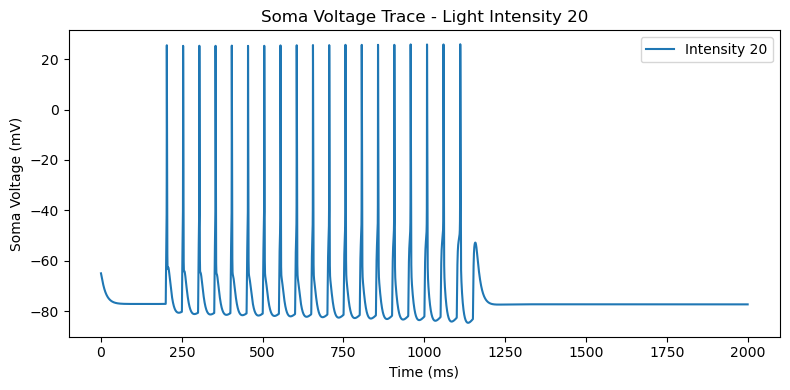

In [6]:
for idx, intensity in enumerate(intensities):
    plt.figure(figsize=(8,4))
    plt.plot(np.array(t), v_traces[idx], label=f'Intensity {intensity}')
    plt.xlabel('Time (ms)')
    plt.ylabel('Soma Voltage (mV)')
    plt.title(f'Soma Voltage Trace - Light Intensity {intensity}')
    plt.legend()
    plt.tight_layout()
    plt.show()